Before reading, make sure to review

- [MVC prgramming](http://en.wikipedia.org/wiki/Model%E2%80%93view%E2%80%93controller)
- [Backbone.js](https://www.codeschool.com/courses/anatomy-of-backbonejs)
- [The widget IPEP](https://github.com/ipython/ipython/wiki/IPEP-23%3A-Backbone.js-Widgets)
- [The original widget PR discussion](https://github.com/ipython/ipython/pull/4374)

In [1]:
from __future__ import print_function # For py 2.7 compat

import ipywidgets as widgets # Widget definitions
from IPython.display import display # Used to display widgets in the notebook
from traitlets import Unicode # Used to declare attributes of our widget

# Abstract

This notebook implements a custom date picker widget,
in order to demonstrate the widget creation process.

To create a custom widget, both Python and JavaScript code is required.

# Section 1 - Basics

## Python

When starting a project like this, it is often easiest to make a simple base implementation,
to verify that the underlying framework is working as expected.
To start, we will create an empty widget and make sure that it can be rendered.
The first step is to define the widget in Python.

In [2]:
class DateWidget(widgets.DOMWidget):
    _view_name = Unicode('DatePickerView').tag(sync=True)

Our widget inherits from `widgets.DOMWidget` since it is intended that it will be displayed in the notebook directly.
The `_view_name` trait is special; the widget framework will read the `_view_name` trait to determine what Backbone view the widget is associated with.
**Using `sync=True` is very important** because it tells the widget framework that that specific traitlet should be synced between the front- and back-ends.

## JavaScript

In the IPython notebook [require.js](http://requirejs.org/) is used to load JavaScript dependencies.
All Jupyter widget code depends on `jupyter-js-widgets`, where the base widget model and base view are defined.
We use require.js to load this file:

In [3]:
%%javascript

require(["jupyter-js-widgets"], function(widgets) {

});

<IPython.core.display.Javascript object>

Now we need to define a view that can be used to represent the model.
To do this, the `DOMWidgetView` is extended.
**A render function must be defined**.
The render function is used to render a widget view instance to the DOM.
For now, the render function renders a div that contains the text *Hello World!*
Lastly, the view needs to be registered with the widget manager, for which we need to load another module.

**Final JavaScript code below:**

In [4]:
%%javascript

require(["jupyter-js-widgets"], function(widgets) {
    
    // Define the DatePickerView
    var DatePickerView = widgets.DOMWidgetView.extend({
        render: function() { this.$el.text('Hello World!'); },
    });
    
    // Register the DatePickerView with the widget manager.
    widgets.ManagerBase.register_widget_view('DatePickerView', DatePickerView);
});

<IPython.core.display.Javascript object>

## Test

To test what we have so far, create the widget, just like you would the builtin widgets:

In [5]:
DateWidget()

# Section 2 - Something useful

## Python

In the last section we created a simple widget that displayed *Hello World!*
To make an actual date widget, we need to add a property that will be synced between the Python model and the JavaScript model.
The new attribute must be a traitlet, so the widget machinery can handle it.
The traitlet must be constructed with a `sync=True` keyword argument, to tell the widget machinery knows to synchronize it with the front-end.
Adding this to the code from the last section:

In [6]:
class DateWidget(widgets.DOMWidget):
    _view_name = Unicode('DatePickerView').tag(sync=True)
    value = Unicode().tag(sync=True)

## JavaScript

In the JavaScript, there is no need to define counterparts to the traitlets.
When the JavaScript model is created for the first time,
it copies all of the traitlet `sync=True` attributes from the Python model.
We need to replace *Hello World!* with an actual HTML date picker widget.

In [7]:
%%javascript

require(["jupyter-js-widgets"], function(widgets) {
    
    // Define the DatePickerView
    var DatePickerView = widgets.DOMWidgetView.extend({
        render: function() {
            
            // Create the date picker control.
            this.$date = $('<input />')
                .attr('type', 'date')
                .appendTo(this.$el);
        },
    });
    
    // Register the DatePickerView with the widget manager.
    widgets.ManagerBase.register_widget_view('DatePickerView', DatePickerView);
});

<IPython.core.display.Javascript object>

In order to get the HTML date picker to update itself with the value set in the back-end, we need to implement an `update()` method.

In [8]:
%%javascript

require(["jupyter-js-widgets"], function(widgets) {
    
    // Define the DatePickerView
    var DatePickerView = widgets.DOMWidgetView.extend({
        render: function() {
            
            // Create the date picker control.
            this.$date = $('<input />')
                .attr('type', 'date')
                .appendTo(this.$el);
        },
        
        update: function() {
            
            // Set the value of the date control and then call base.
            this.$date.val(this.model.get('value')); // ISO format "YYYY-MM-DDTHH:mm:ss.sssZ" is required
            return DatePickerView.__super__.update.apply(this);
        },
    });
    
    // Register the DatePickerView with the widget manager.
    widgets.ManagerBase.register_widget_view('DatePickerView', DatePickerView);
});

<IPython.core.display.Javascript object>

To get the changed value from the frontend to publish itself to the backend,
we need to listen to the change event triggered by the HTM date control and set the value in the model.
After the date change event fires and the new value is set in the model,
it is very important that we call `this.touch()` to let the widget machinery know which view changed the model.
This is important because the widget machinery needs to know which cell to route the message callbacks to.

**Final JavaScript code below:**

In [9]:
%%javascript


require(["jupyter-js-widgets"], function(widgets) {
    
    // Define the DatePickerView
    var DatePickerView = widgets.DOMWidgetView.extend({
        render: function() {
            
            // Create the date picker control.
            this.$date = $('<input />')
                .attr('type', 'date')
                .appendTo(this.$el);
        },
        
        update: function() {
            
            // Set the value of the date control and then call base.
            this.$date.val(this.model.get('value')); // ISO format "YYYY-MM-DDTHH:mm:ss.sssZ" is required
            return DatePickerView.__super__.update.apply(this);
        },
        
        // Tell Backbone to listen to the change event of input controls (which the HTML date picker is)
        events: {"change": "handle_date_change"},
        
        // Callback for when the date is changed.
        handle_date_change: function(event) {
            this.model.set('value', this.$date.val());
            this.touch();
        },
    });
    
    // Register the DatePickerView with the widget manager.
    widgets.ManagerBase.register_widget_view('DatePickerView', DatePickerView);
});

<IPython.core.display.Javascript object>

## Test

To test, create the widget the same way that the other widgets are created.

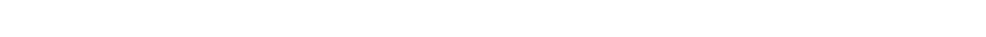

In [10]:
my_widget = DateWidget()
display(my_widget)

Display the widget again to make sure that both views remain in sync.

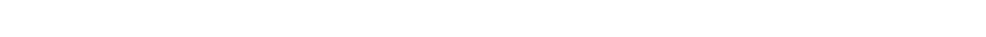

In [11]:
my_widget

Read the date from Python

In [12]:
my_widget.value

'1990-06-12'

Set the date from Python

In [13]:
my_widget.value = "1998-12-01" # December 1st, 1998

# Section 3 - Extra credit

The 3rd party `dateutil` library is required to continue.  https://pypi.python.org/pypi/python-dateutil

In [14]:
# Import the dateutil library to parse date strings.
from dateutil import parser

In the last section we created a fully working date picker widget.
Now we will add custom validation and support for labels.
So far, only the ISO date format "YYYY-MM-DD" is supported.
Now, we will add support for all of the date formats recognized by the Python dateutil library.

## Python

The standard property name used for widget labels is `description`.
In the code block below, `description` has been added to the Python widget.

In [15]:
class DateWidget(widgets.DOMWidget):
    _view_name = Unicode('DatePickerView').tag(sync=True)
    value = Unicode().tag(sync=True)
    description = Unicode().tag(sync=True)

The traitlet machinery searches the class that the trait is defined in for methods with "`_changed`" suffixed onto their names.  Any method with the format "`_X_changed`" will be called when "`X`" is modified.
We can take advantage of this to perform validation and parsing of different date string formats.
Below, a method that listens to value has been added to the DateWidget.

In [16]:
class DateWidget(widgets.DOMWidget):
    _view_name = Unicode('DatePickerView').tag(sync=True)
    value = Unicode().tag(sync=True)
    description = Unicode().tag(sync=True)

    # This function automatically gets called by the traitlet machinery when
    # value is modified because of this function's name.
    def _value_changed(self, name, old_value, new_value):
        pass

Now the function parses the date string,
and only sets the value in the correct format.

In [17]:
class DateWidget(widgets.DOMWidget):
    _view_name = Unicode('DatePickerView').tag(sync=True)
    value = Unicode().tag(sync=True)
    description = Unicode().tag(sync=True)
    
    # This function automatically gets called by the traitlet machinery when
    # value is modified because of this function's name.
    def _value_changed(self, name, old_value, new_value):
        
        # Parse the date time value.
        try:
            parsed_date = parser.parse(new_value)
            parsed_date_string = parsed_date.strftime("%Y-%m-%d")
        except:
            parsed_date_string = ''
        
        # Set the parsed date string if the current date string is different.
        if self.value != parsed_date_string:
            self.value = parsed_date_string

Finally, a `CallbackDispatcher` is added so the user can perform custom validation.
If any one of the callbacks registered with the dispatcher returns False,
the new date is not set.

**Final Python code below:**

In [18]:
class DateWidget(widgets.DOMWidget):
    _view_name = Unicode('DatePickerView').tag(sync=True)
    value = Unicode().tag(sync=True)
    description = Unicode().tag(sync=True)
    
    def __init__(self, **kwargs):
        super(DateWidget, self).__init__(**kwargs)
        
        self.validate = widgets.CallbackDispatcher()
    
    # This function automatically gets called by the traitlet machinery when
    # value is modified because of this function's name.
    def _value_changed(self, name, old_value, new_value):
        
        # Parse the date time value.
        try:
            parsed_date = parser.parse(new_value)
            parsed_date_string = parsed_date.strftime("%Y-%m-%d")
        except:
            parsed_date_string = ''
        
        # Set the parsed date string if the current date string is different.
        if old_value != new_value:
            valid = self.validate(parsed_date)
            if valid in (None, True):
                self.value = parsed_date_string
            else:
                self.value = old_value
                self.send_state() # The traitlet event won't fire since the value isn't changing.
                                  # We need to force the back-end to send the front-end the state
                                  # to make sure that the date control date doesn't change.

## JavaScript

Using the Javascript code from the last section,
we add a label to the date time object.
The label is a div with the `widget-hlabel` class applied to it.
`widget-hlabel` is a class provided by the widget framework that applies special styling to a div to make it look like the rest of the horizontal labels used with the built-in widgets.
Similar to the `widget-hlabel` class is the `widget-hbox-single` class.
The `widget-hbox-single` class applies special styling to widget containers that store a single line horizontal widget.

We hide the label if the description value is blank.

In [19]:
%%javascript

require(["jupyter-js-widgets"], function(widgets) {
    
    // Define the DatePickerView
    var DatePickerView = widgets.DOMWidgetView.extend({
        render: function() {
            this.$el.addClass('widget-hbox-single'); /* Apply this class to the widget container to make
                                                        it fit with the other built in widgets.*/
            // Create a label.
            this.$label = $('<div />')
                .addClass('widget-hlabel')
                .appendTo(this.$el)
                .hide(); // Hide the label by default.
            
            // Create the date picker control.
            this.$date = $('<input />')
                .attr('type', 'date')
                .appendTo(this.$el);
        },
        
        update: function() {
            
            // Set the value of the date control and then call base.
            this.$date.val(this.model.get('value')); // ISO format "YYYY-MM-DDTHH:mm:ss.sssZ" is required
            
            // Hide or show the label depending on the existance of a description.
            var description = this.model.get('description');
            if (description == undefined || description == '') {
                this.$label.hide();
            } else {
                this.$label.show();
                this.$label.text(description);
            }
            
            return DatePickerView.__super__.update.apply(this);
        },
        
        // Tell Backbone to listen to the change event of input controls (which the HTML date picker is)
        events: {"change": "handle_date_change"},
        
        // Callback for when the date is changed.
        handle_date_change: function(event) {
            this.model.set('value', this.$date.val());
            this.touch();
        },
    });
    
    // Register the DatePickerView with the widget manager.
    widgets.ManagerBase.register_widget_view('DatePickerView', DatePickerView);
});

<IPython.core.display.Javascript object>

## Test

To test the drawing of the label we create the widget like normal but supply the additional description property a value.

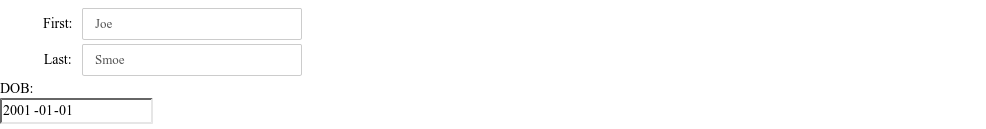

In [20]:
# Add some additional widgets for aesthetic purpose
display(widgets.Text(description="First:"))
display(widgets.Text(description="Last:"))

my_widget = DateWidget()
display(my_widget)
my_widget.description="DOB:"

Now we will try to create a widget that only accepts dates in the year 2014.  We render the widget without a description to verify that it can still render without a label.

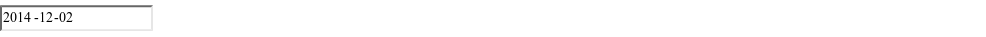

In [ ]:
my_widget = DateWidget()
display(my_widget)

def require_2014(date):
    return not date is None and date.year == 2014
my_widget.validate.register_callback(require_2014)

In [22]:
# Try setting a valid date
my_widget.value = "December 2, 2014"

In [23]:
# Try setting an invalid date
my_widget.value = "June 12, 1999"

In [24]:
my_widget.value

'2014-12-02'